Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [2]:
from glob import glob

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
# Printing the image count in the Train and Test set
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
num_classes= 9
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32, image_size=(180, 180), seed=123, validation_split=0.2, subset= "training")##todo

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32, image_size=(180, 180), seed=123, validation_split=0.2, subset= "validation") ##todo


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

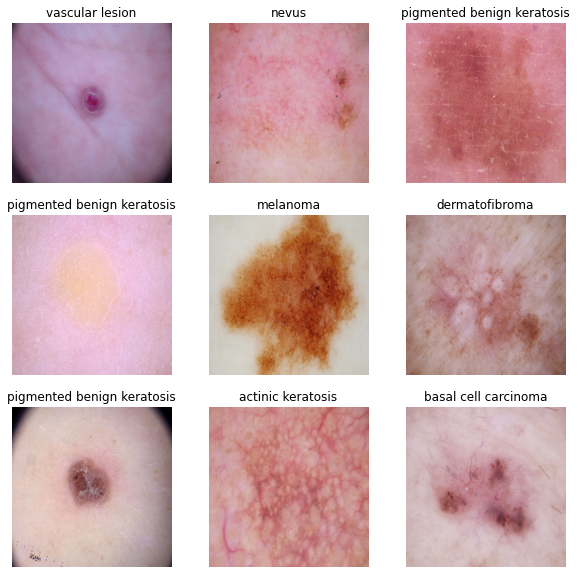

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
model = Sequential(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255))
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 277s 1s/step - loss: 2.2361 - accuracy: 0.2690 - val_loss: 1.8206 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 1.7005 - accuracy: 0.3917 - val_loss: 1.6020 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4880 - accuracy: 0.4799 - val_loss: 1.4176 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3419 - accuracy: 0.5290 - val_loss: 1.3889 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2620 - accuracy: 0.5569 - val_loss: 1.4110 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2052 - accuracy: 0.5675 - val_loss: 1.3761 - val_accuracy: 0.5615
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.1737 - accuracy: 0.5876 - val_loss: 1.4365 - val_accuracy: 0.5257
Epoch 8/20
56/56 [======

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0

### Visualizing training results

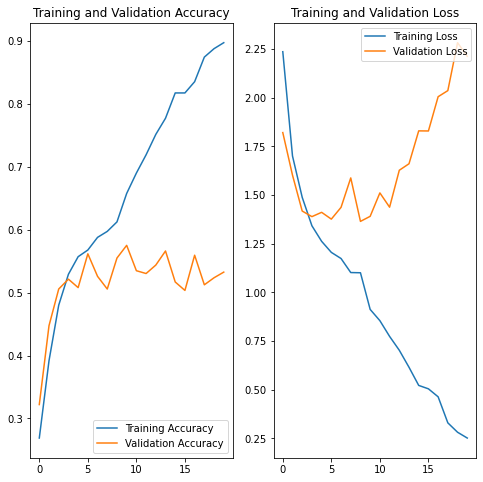

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Analysis:** The difference between the training and validation accuracy is high. The training accuracy is much higher that the validation accuracy. Thus, represents the model is over fitted. 

### To resolve this, we will use random flip data augmentation. 

In [18]:
# data augmentation
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(180,180,3)),
layers.experimental.preprocessing.RandomRotation(0.2,fill_mode='reflect'),layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3),width_factor= (0.2,0.3), fill_mode="reflect")])

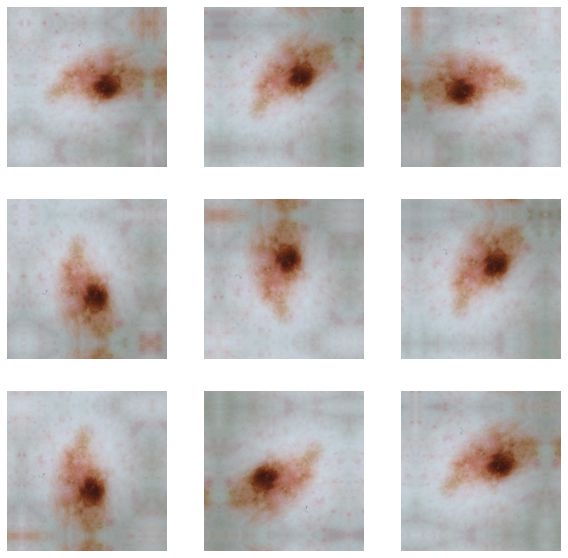

In [19]:
# visualize how your augmentation strategy works for one instance of training image.
fig = plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## using Dropout layer as our previous model had overfitted
model = Sequential([data_augmentation,layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compiling the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:
# training model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 4s 49ms/step - loss: 3.1739 - accuracy: 0.1853 - val_loss: 2.1168 - val_accuracy: 0.1991
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9897 - accuracy: 0.2260 - val_loss: 1.9226 - val_accuracy: 0.3490
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.7202 - accuracy: 0.3800 - val_loss: 1.6217 - val_accuracy: 0.4318
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6560 - accuracy: 0.4012 - val_loss: 1.7232 - val_accuracy: 0.3915
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6087 - accuracy: 0.4230 - val_loss: 1.5969 - val_accuracy: 0.4519
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5844 - accuracy: 0.4347 - val_loss: 1.6003 - val_accuracy: 0.4609
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4896 - accuracy: 0.4777 - val_loss: 1.4621 - val_accuracy: 0.4653
Epoch 8/20
56/56 [======

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 64)       

### Visualizing the results

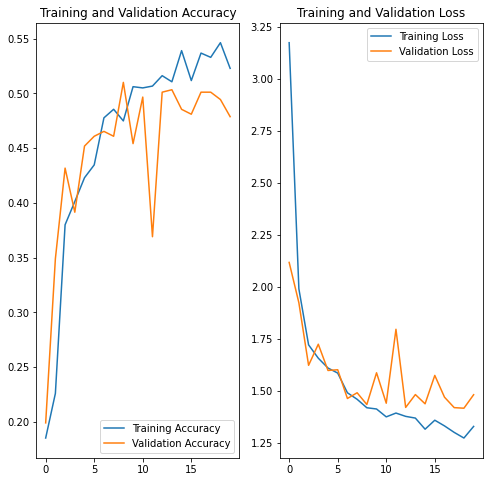

In [24]:
# visualizing the results of the model 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### **Analysis:** Post adding data augmentation, the difference between the training and validation accurary is low. Hence, there are no evidences of over fitting now as compared to the previous model. 

### But the accuracy is low. to improve this, we will use augmentor, i.e. adding more samples across all classes so that none of the classes have very few samples and there are sufficient samples for the model to be trained properly and analyze the data.

#### **Find the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
# creating data frame for the original data set
path_list=[]
lesson_list=[]
for i in class_names:

  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesson_list.append(i)
    dataframe_dict_original = dict(zip(path_list, lesson_list))
    original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label']) 
    original_df

In [26]:
# checking the image count for each of the classes in the dataset
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

### **Findings:** 
### - Which class has the least number of samples?
### -> **seborrheic keratosis**
### - Which classes dominate the data in terms proportionate number of samples?
### -> **pigmented benign keratosis*


#### **Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
# installing Augmentor
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC3605E450>: 100%|██████████| 500/500 [00:19<00:00, 26.01 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC3605E8D0>: 100%|██████████| 500/500 [00:18<00:00, 26.39 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC361F1550>: 100%|██████████| 500/500 [00:20<00:00, 24.96 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FAC362E9AD0>: 100%|██████████| 500/500 [01:28<00:00,  5.66 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7FAC12100610>: 100%|██████████| 500/500 [01:20<00:00,  6.23 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAC12114310>:   0%|          | 1/500 [00:00<00:46, 10.64 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC1213C2D0>: 100%|██████████| 500/500 [00:19<00:00, 25.53 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAC120A4990>: 100%|██████████| 500/500 [00:41<00:00, 12.19 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAC120A4310>:   0%|          | 1/500 [00:00<00:56,  8.85 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC362E9E90>: 100%|██████████| 500/500 [00:18<00:00, 26.79 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC121AE210>: 100%|██████████| 500/500 [00:19<00:00, 25.40 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028448.jpg_58adee22-1a28-4085-841f-9ed20c207b4c.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028120.jpg_82d7bb39-eb9b-409f-abf4-e82b00350067.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024711.jpg_fed7f038-4d7d-408d-bc23-54da977fecd9.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028593.jpg_09cd1e02-05ab-4cdf-9c4c-2158965f7cca.jpg',
 '/content/gdrive/MyDrive/Colab Notebook

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [32]:
#Creating dataframe of the augmented images
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
# Combining the original and augmented data frame
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
# Checking the image count for all the classes post the addition of the augmented data
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Train the model on the data created using Augmentor**

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Create a training dataset**

In [36]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Create a validation dataset**

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Create your model**

In [38]:
model = Sequential(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255))
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#### **Compile your model**

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Train your model**

In [40]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 37s 212ms/step - loss: 2.4865 - accuracy: 0.1408 - val_loss: 2.1864 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 36s 209ms/step - loss: 2.0796 - accuracy: 0.2025 - val_loss: 1.8456 - val_accuracy: 0.3088
Epoch 3/30
169/169 [==============================] - 36s 209ms/step - loss: 1.6002 - accuracy: 0.3861 - val_loss: 1.5063 - val_accuracy: 0.4246
Epoch 4/30
169/169 [==============================] - 36s 210ms/step - loss: 1.4379 - accuracy: 0.4564 - val_loss: 1.3535 - val_accuracy: 0.4826
Epoch 5/30
169/169 [==============================] - 36s 209ms/step - loss: 1.3042 - accuracy: 0.5007 - val_loss: 1.2435 - val_accuracy: 0.5167
Epoch 6/30
169/169 [==============================] - 36s 208ms/step - loss: 1.1782 - accuracy: 0.5480 - val_loss: 1.3324 - val_accuracy: 0.5174
Epoch 7/30
169/169 [==============================] - 36s 209ms/step - loss: 1.1298 - accuracy: 0.5816 - val_loss: 1.0939 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

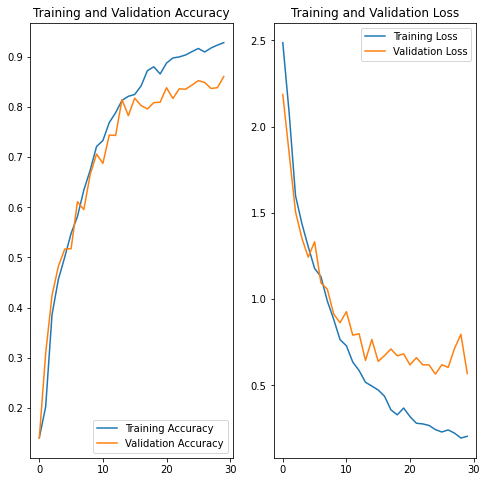

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Analysis:** The class rebalance, helped in getting  good training and validation accuracy. 
### There are no evidences for overfitting / underfitting of the model. 

### **Conclusion:**
###  -> **First model:** We observed that the difference between the training and validation accuracy is high, thus reflecting overfitting of the model. 

### -> To resolve the overfitting, we used random flip data augmentation. 

### -> **Second Model:** With the use of data augmentation, we reduced the overfitting of the model and the difference between training and validation accuracy lowered down. But the model's overall performance is low, thus reflecting that the model can be improved further. 

### -> To improve the model, we used augmentor. 

### -> **Third Model:** Using new data set (original data set+ augmented data set),  the model's performenace improved a lot. The difference between the training and validation accuracy is low, thus reflecting that there is not overfitting / underfiting of the model. And the model's overall performance is good. Thus indicating that the model is a good fit. 
